# PIT for Conditional Flows
Project idea based on [this paper](https://arxiv.org/abs/2102.10473). 

Using the `nflows` library for flow implementations.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import math

import torch.distributions as D
from scipy.stats import multivariate_normal, norm

from nde.train import train
from nde.flows import construct_maf, cdf_flow
from plot import plot_pdf_1D
from diagnostics.pp_plots import (
    cde_pit_values,
    PP_plot_1D,
    PP_vals,
    compare_pp_plots_regression,
)
from diagnostics.localPIT_regression import (
    localPIT_regression_baseline,
    localPIT_regression_grid,
    localPIT_regression_sample,
    run_localPIT_regression,
)

from data.data_generators import ConditionalGaussian1d
from data.feature_transforms import identity, first_dim_only


## CONTEXT (1D)

Consider the 1D conditional target distribution $f_{\Theta\mid X}$ with **unknown density** and we have **no samples**.

We only have access to samples from the joint distribution $f_{X,\Theta}$: $\quad (\Theta_1,X_1), \dots, (\Theta_n, X_n) \sim f_{X,\Theta}$

Our estimator $f_{Q\mid X}$ is a *Normalizing Flow* whose density is **explicitly known**. It is defined by a base distribution $p_U$ (tipically gaussian) and a bijective transformation $T_{\phi}$: 
$$U\sim p_U \rightarrow Q=T_{\phi}(U, X) \sim f_{Q\mid X}$$ 
$$f_{Q\mid X}(q) = p_{U}\left(T_{\phi}^{-1}(q, X)\right)\left|\operatorname{det} J_{T_{\phi}^{-1}}(q, X)\right|$$ 

Note that we can also define it's c.d.f. explicitly for a fixed $X=x_0$: $\quad F_{Q\mid X=x_0}(q) = \mathbb{P}(Q\leq q \mid X=x_0) =\mathbb{P}(T_{\phi}(U, x_0)\leq q)=\mathbb{P}(U\leq T_{\phi}^{-1}(q, x_0))=F_U(T_{\phi}^{-1}(q, x_0))$

We wish to know evaluate our estimator, with the same method as in the non-conditional case, i.e. with the PIT:

$$\text{PIT}(\theta, x ; f_{Q\mid X}) = \mathbb{P}(Q\leq \theta \mid X=x) = F_{Q \mid X=x}(\theta)$$

## EVALUATION
### True PIT-distribution / Local Consistency
For a fixed $X = x_0$ and $\Theta \sim f_{\Theta \mid X=x_0}$:
$$\begin{aligned} 
f_{Q\mid x_0} = f_{\Theta\mid x_0} & \iff \text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \sim \mathcal{U}(0,1)\\
& \iff \mathbb{P}_{\Theta \mid x_0}(\text{PIT}(\Theta, x_0 ; f_{Q\mid X})) \leq \alpha) = \alpha, \quad \forall \alpha \in [0,1]\\
& \iff F_{\Theta \mid X=x_0}(F_{Q \mid X=x_0}^{-1}(\alpha)) = \alpha, \quad \forall \alpha \in [0,1]
\end{aligned}$$

We find ourselves with the same result as in the non-conditional 1D case , as $X$ is fixed at $x_0$ (cf. Theorem 2 in paper). 

**Problem:** We are unable to compute the c.d.f. of the target distribution $F_{\Theta \mid X=x_0}$, as the density $f_{\Theta \mid x_0}$ is unknown and no samples $\theta_i \mid x_0$ are available to approximate it empirically.

### Expected PIT-distribution over $X$ / Global Consistency 
We can however compute the empirical **expected c.d.f. over $X$** by using the samples from the joint distribution. 

$$\begin{aligned}
\mathbb{E}_X[F_{\Theta\mid X}(F_{Q\mid X}(\alpha)^{-1})] & = \mathbb{E}_X[\mathbb{P}_{\Theta\mid X}(F_{Q\mid X}(\Theta)\leq \alpha)]\\
& = \mathbb{E}_X[\mathbb{E}_{\Theta\mid X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]]\\
& = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}]\\
& \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}
\end{aligned}$$

This gives us an approximation of the **expected (or joint) PIT-distribution:** 

$$\mathbb{E}_X[\mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha)] = \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) = \mathbb{E}_{\Theta, X}[\mathbb{1}_{\{F_{Q\mid X}(\Theta)\leq \alpha\}}] \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{\{F_{Q\mid X_i}(\Theta_i)\leq \alpha\}}$$

#### Result 1: 
It is still true that if $\forall X, f_{Q\mid X} = f_{\Theta\mid X} $ (global consistency) and $\Theta, X \sim f_{\Theta, X}$, the *joint PIT-distribution* is uniform:

$$f_{Q\mid X} = f_{\Theta\mid X} \Rightarrow \mathbb{P}_{\Theta,X}(\text{PIT}(\Theta, X; f_{Q\mid X})\leq \alpha) =\alpha, \quad \forall \alpha \in [0,1]$$

**Problem:** The reverse is not true! This quantity does not allow us to evaluate our estimator (i.e. check global concistency) in a reliable way: we can find globally non-consistent estimators ($f_{Q\mid X} \neq f_{\Theta\mid X}$), but whose joint PIT-distribution is uniform. 

#### Result 2: 
Uniformity of the expected PIT-distribution holds for any estimator $f_{Q\mid X} = f_{\Theta\mid g(X)}$ with $g$ a given function (cf. Theorem 1 in paper).

#### Proofs can be found [here](https://notes.inria.fr/s/rhHwKKzaK).

### Global vs. Local Consistency: Illustration via Code 

Let's look at some code to illustrate this.

We consider a target density $\Theta\mid X \sim \mathcal{N}(X_1+X_2, 1)$ with $X = (X_1, X_2) \sim \mathcal{N}(\mu, \Sigma)$ where $\mu = [\mu_1, \mu_2]$ and $\Sigma = \begin{pmatrix} \sigma_{1}^2 & \rho \sigma_1 \sigma_2\\ \rho \sigma_1 \sigma_2 & \sigma_{2}^2 \end{pmatrix}$.



In [2]:
# GLOBAL PARAMETER
ALPHAS = np.linspace(0, 0.999, 100)

#### DATA Generation of Toy-model


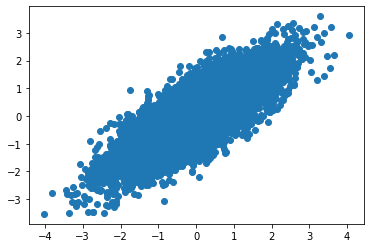

In [3]:
# nb samples (same as in code from paper)
n = 10_500
# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d()
# Samples from the joint distribution P(Theta,X) = P(X)*P(Theta|X)
samples_x, samples_theta = data_gen.get_joint_data(n=n)


# plot X-distribution
plt.scatter(samples_x[:, 0], samples_x[:, 1])
plt.show()


#### Result 1: Uniformity of the expected PIT-distribution

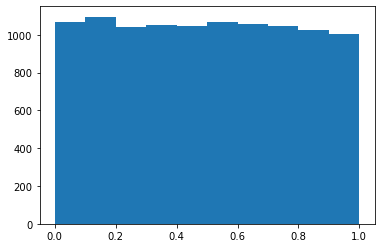

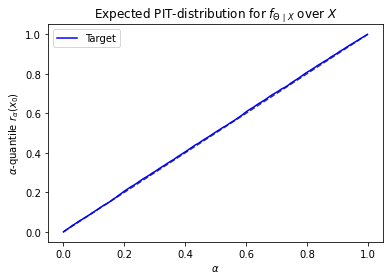

In [4]:
# PLOT EXPECTED PIT-DISTRIBUTION for the true distribution Theta|X

# Joint PIT-values [PIT(Theta_i, X_i, f_{Theta|X})]
true_joint_pit_values = data_gen.true_pit_values(samples_theta, samples_x)

# Plot histogram of expected PIT-distribution
plt.hist(true_joint_pit_values)
plt.show()

# PP-plot of expected PIT-distribution
PP_plot_1D(
    PIT_values=[true_joint_pit_values],
    alphas=ALPHAS,
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
)


#### Result 2: Uniformity of globally non-consistent estimators
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [5]:
# Get train, val and test samples:
# - train samples are used to train the flow,
# - test samples are used to compute/learn the PIT-distribution

# Split in train/test sets (same as in code from paper)
train_size = 10_000  # test_size = 500
x_train, x_test = samples_x[:train_size], samples_x[train_size:]
theta_train, theta_test = samples_theta[:train_size], samples_theta[train_size:]

print("NB training samples: ", x_train.shape)
print("NB test samples: ", x_test.shape)


NB training samples:  torch.Size([10000, 2])
NB test samples:  torch.Size([500, 2])


In [6]:
# TRAIN FLOWS

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=False
)

# ... trained on X=(X_1,X_2)
best_val_loss_good, epochs_good = train(
    maf_good,
    theta_train,
    context=x_train,  # X=(X_1,X_2)
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=False
)

# trained on g(X)=(X_1)
g = first_dim_only
best_val_loss_bad, epochs_bad = train(
    maf_bad,
    theta_train,
    context=g(x_train),  # g(X)=(X_1)
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)

##### Global Consistency

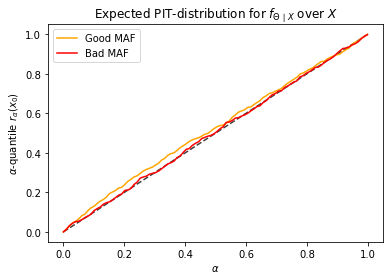

In [7]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values(

    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=ALPHAS,
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Expected PIT-distribution for $f_{\Theta \mid X}$ over $X$",
)


Both estimators have uniform PIT-distribution, but the bad MAF is not globally consistent. 

Indeed, the code below will show that the bad MAF is locally inconsistent, which implies also that it cannot be globally consistent.

##### Local Consistency

/Users/julialinhart/Documents/Code/github/valDiags_flows/plot.py:11: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1,1)


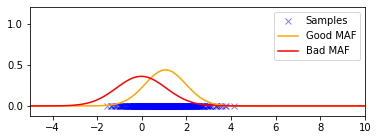

In [8]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_test))]
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


We can already see that the two flows disagree. Espcially in the variance. 

This was not represented in the global pp-plot, but can be visualized via the local pp-plot (see code below).

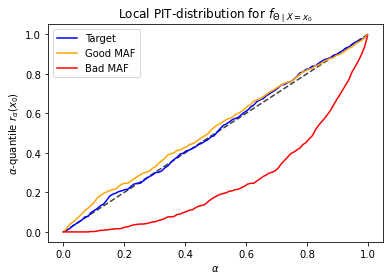

In [9]:
# Local PIT-distribution on samples Theta_i from Theta|X=x_0

# Compute PIT-values [PIT(Theta_i, X=x_0, f_true/good/bad) = F_{Q|X_i}(Theta_i)]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values(
    samples_theta_x, x_0, flow=maf_good, feature_transform=identity, local=True
)
flow_local_pit_values_bad = cde_pit_values(
    samples_theta_x, x_0, flow=maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=ALPHAS,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$",
)


Indeed, the variance distorsion of the bad MAF is clearly visible in this pp-plot (red line in S-shape). 

This shows that if our function $g(X)$ doas not caracterize covariate relations between the elements of $X$ (e.g. non-sufficient summary statistics), the expected PIT-distribution will not show us the error, whereas the local PIT-distribution does.

We need a way to claculate the local PIT-distribution! 

## Estimating the Local PIT-Distribution

We define the $\alpha$-quantile of the local PIT-distribution as follows:

$$ r_{\alpha}(X) = \mathbb{P}_{\Theta \mid X}(\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha) = \mathbb{E}[\mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}\mid X]$$

### Method 1 proposed by [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473): 
**Regression of $W^{\alpha} = \mathbb{1}_{\{\text{PIT}(\Theta, X ; f_{Q\mid X}) \leq \alpha\}}$ on $X$, using samples from the joint $(\Theta_i, X_i) \sim f_{\Theta, X}$.**

The goal is to estimate the random variable $W^{\alpha}$ as a function $f$ of $X$. 

Theoretically, the optimal solution of this regression problem - in terms of $L^2$-distance $E\left[(W^{\alpha} - f(X))^2\right]$ - is the conditional expectation $f^{\star}(X) = \mathbb{E}[W^{\alpha} \mid X] = r_{\alpha}(X)$ (it corresponds to the othogonal projection of $W^{\alpha}$ on $L^2(\Omega, \mathcal{F}(X), \mathbb{P}) = L^2_X$).

#### Algorithm:
1. pre-compute $W^{\alpha}_i$ using the avalable samples $\Theta_i, X_i$
2. regress $W^{\alpha}_i$ on $X_i$ to get an estimate of $r_{\alpha}(X)$
3. evaluate $r_{\alpha}$ in $X=x_0$
4. plot $r_{\alpha}(x_0)$ as a function of $\alpha$ and compare to identity

#### Comments
- This is actually a binary classifiacation problem 
- We need to use a regressor / classifier that has an optimum defined by the conditional expectation! Different loss function (i.e. classifiers) can be used (cf. [On Loss Functions Which Minimii to Conditional Expected Values and Posterior Probabilities](https://authors.library.caltech.edu/93850/1/00243457.pdf)). Here they use `sklearn.MLPClassifier` trained with a log-loss (compatible).
- There is a monotonic coupling / ordering between $r_{\alpha}(X)$ and $\alpha$: $r_{\alpha}(X) \nearrow \alpha$
    - cf. [isotonic regression with monotonic constraint in sklearn](https://scikit-learn.org/stable/modules/isotonic.html) (//calibration with binary target variable)
    - what about the multivariate case? cf. Random Forest for multi-output with monotonic splitting criteria?
    - implement existing method and analyse if monotonic or not in $\alpha$


#### Implementation of the Regression Method from [[Zhao et. al, UAI 2021]](https://arxiv.org/abs/2102.10473):

In [10]:
# Training set for regression task: Samples from the joint !
# test set used for empirical approximations earlier
theta_train_PIT = theta_test
x_train_PIT = x_test

# PIT-values [PIT(Theta_i, X_i, flow)] used to compute labels 
pit_values_train_good = flow_joint_pit_values_good.ravel()
pit_values_train_bad = flow_joint_pit_values_bad.ravel()

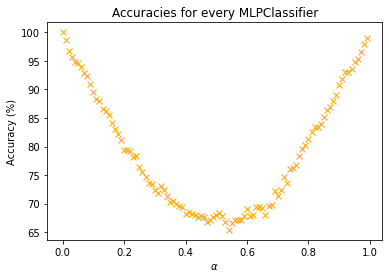

Mean training accuracy:  78.824


In [11]:
# Estimate local PIT-distribution quantiles for bad MAF
# Train several classifiers for each alpha value 
# Evaluate every classifier in x_0
r_alpha_test, accuracies = localPIT_regression_baseline(
    alphas=np.linspace(0,0.99,100), 
    pit_values_train=pit_values_train_bad, # pit-values used to compute the targets
    x_train=x_train_PIT,
    x_eval=x_0.numpy(), # evaluation sample x_0
)

# Plot accuracies as a function of alpha
accuracies = pd.Series(accuracies)
accuracies.plot(style="x", color="orange")
plt.title(r"Accuracies for every MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Accuracy (%)")
plt.show()
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

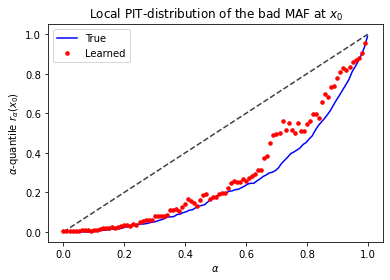

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.606
Mean training accuracy:  78.824
Monotonicity: 70.71% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


In [12]:
# Local PP-plot
r_alpha_test = pd.Series(r_alpha_test)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = r_alpha_test,
    colors=["blue"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, np.array(r_alpha_test))
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Mean training accuracy: ", np.round(np.mean(accuracies), 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(np.array(r_alpha_test)) >= 0)
print(
    f"Monotonicity: {np.round(monotonicity*100,2)}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)


Errors:
- logisticregressor doesnt work because needs 2 classes in training data. 
- Isotonic regression doesn't work because 'input X should be a 1d array or 2d array with 1 feature'. Anyway it should be increasing with alpha and not x.
- if including 1 in the alphas list, we get an outlier in the prediction

Comments:
- MLP trained for classification with the `log_loss`: $L_{\log }(y, p)=-(y \log (p)+(1-y) \log (1-p))$
- $p=$`predict_proba[:,1]` gives the probability of the **class $1$**, the success class of being $\leq \alpha$
- The classifiers are less accurate in the middle range, which is exactly what we expect: 
    - the goal is to plot the miscalibration of the probabilities, so it is normal that the accuracies drop for a miscalibrated problem: **Accuracy is not the right metric here!** 
    - cf. comparison to `Dummy` whose accuracy drops to $0.5$ at $\alpha = 0.5$ (linear function)


### Amortized in alpha 

**Idea: Only one Classifier on alpha and X:**
- can make relationship between r_alpha and alpha explicit and thus learn the monotonic constraint? 
- converges to what theoretically?

#### Method 2: 
Expand the training-set to take into account all ${\alpha_t}$ $\in$ `np.linspace(0,1,T)`:
- new targets: $W^{\alpha_t}_i$ for all $\alpha_t$ and $(\Theta_i, X_i)$
- new features **including $\alpha$**: $\{(X_0,\alpha_t), \dots, (X_n,\alpha_t)\}$ for all $\alpha_t$

The size is multiplied by the number $T$ of $\alpha$-values (here $T=101$)


In [13]:
# Estimate the local PIT
# Train the Classifier amortized on x and all alphas
# Evaluate in x_0 and for all alphas
r_alpha_test_grid, train_accuracy_grid, losses_grid, _ = localPIT_regression_grid(
    alphas=ALPHAS,
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    x_eval=x_0.numpy(),
)


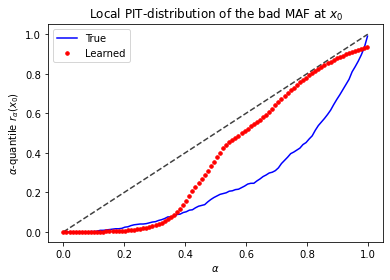

Euclidean Distance to empirical local pit-distribution (ground-truth):  1.914
Training accuracy:  79.854
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


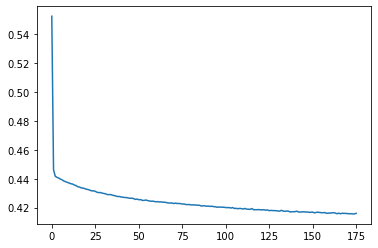

In [14]:
# Local PP-Plot
r_alpha_test_grid = pd.Series(r_alpha_test_grid)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned=r_alpha_test_grid,
    colors=["blue"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_grid)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Training accuracy: ", np.round(train_accuracy_grid, 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_grid) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(losses_grid)
plt.show()

#### Method 3:
Sample $\alpha \sim \mathcal{U}(0,1) $ $T=1$ time for each sample $(\Theta_i, X_i)$ of the joint. 

In [15]:
# Train the Classifier amortized on x and 1 sampled alpha
# Evaluate in x_0 and for all alphas
(
    r_alpha_test_sample,
    train_accuracy_sample,
    losses_sample,
    _,
) = localPIT_regression_sample(
    alphas=ALPHAS,
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=1,
    x_eval=x_0.numpy(),
)


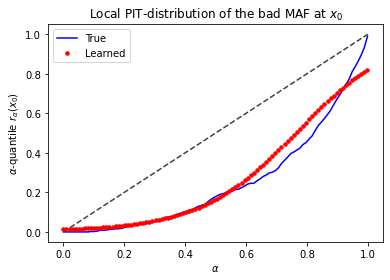

Euclidean Distance to empirical local pit-distribution (ground-truth):  0.496
Training accuracy:  80.6
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


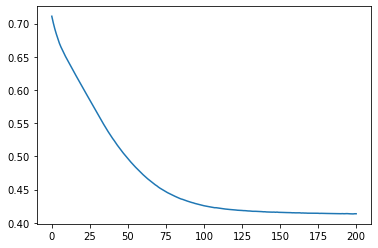

In [16]:
# Local PP-Plot
r_alpha_test_sample = pd.Series(r_alpha_test_sample)
PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = r_alpha_test_sample,
    colors=["blue"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Training accuracy: ", np.round(train_accuracy_sample, 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(losses_sample)
plt.show()


**Comments:**

- The original method needs multiple classifiers (one for each alpha value) is not verifying the monotonic constraint. 
- The in alpha amortized versions insure that the monotonic constrain is respected. BUT depending on the $x_0$ used for evaluation, the amortized versions can be pretty far from the black groundtruth (euclidean distance). 
- We could increase $T$ for method 3 (e.g. $T=20$).
- Accuracy is not the right metric! 
- We should compare the results in one plot: distance to GT (black curve), computational time, number of training samples needed (alpha samples during training and features...)

**TODO:**
- Evaluate the variance of the methods over several trainings of a model evaluated in the same $x_0$ (model uncertainty)
- Evaluate the variance of the methods over several choices of $x_0$ (data uncertainty)
- Plots to visualize comparisons between methods:
    - distance to ground-truth
    - computational cost
    - number of training samples needed
    
Small checks:
- Compare to `LogisticRegression`
- See convergence criteria of `MLPClassifier`
- confidence intervals like in paper code? 
- add constraint (bounds (0,1)?)
- regularize?




In [17]:
# Train the Classifier amortized on x and multiple sampled alpha
# Evaluate in x_0 and for all alphas

(
    r_alpha_test_sample_T,
    train_accuracy_sample_T,
    losses_sample_T,
    _
) = localPIT_regression_sample(
    alphas=ALPHAS,
    pit_values_train=pit_values_train_bad,
    x_train=x_train_PIT,
    nb_samples=50,
    x_eval=x_0.numpy(),
)


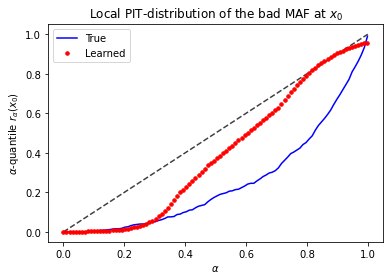

Euclidean Distance to empirical local pit-distribution (ground-truth):  1.923
Training accuracy:  79.764
Monotonicity: 100.0% of the points agree with: 'the alpha-quantile has to be increasing with alpha'.


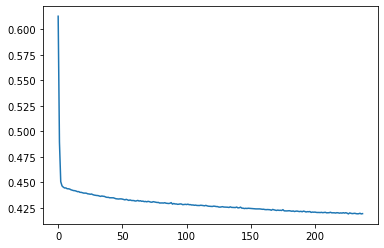

In [18]:
# Local PP-Plot

r_alpha_test_sample_T = pd.Series(r_alpha_test_sample_T)

PP_plot_1D(
    PIT_values=[flow_local_pit_values_bad],
    alphas=ALPHAS,
    r_alpha_learned = r_alpha_test_sample_T,
    colors=["blue"],
    labels=["True"],
    title=r"Local PIT-distribution of the bad MAF at $x_0$",
)

# Evaluation metrics
z_maf_bad_x = PP_vals(flow_local_pit_values_bad, ALPHAS)
euc_dist_to_gt = math.dist(z_maf_bad_x, r_alpha_test_sample_T)
print(
    "Euclidean Distance to empirical local pit-distribution (ground-truth): ",
    np.round(euc_dist_to_gt, 3),
)
print("Training accuracy: ", np.round(train_accuracy_sample_T, 3))

# Check monotonicity of r_alpha
monotonicity = np.mean(np.diff(r_alpha_test_sample_T) >= 0)
print(
    f"Monotonicity: {monotonicity*100}% of the points agree with: 'the alpha-quantile has to be increasing with alpha'."
)

# Plot loss evolution
plt.plot(losses_sample_T)
plt.show()


### Compare Local PIT Regression Methods

#### Show that for grid and sample methods 500 samples are not enough 


In [19]:
# 500 samples

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    localPIT_regression_sample,
]
x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train = run_localPIT_regression(
    methods,
    x_evals,
    nb_train_samples=500,
    alpha_samples=[1, 50],
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _ = run_localPIT_regression(
    methods,
    x_evals,
    nb_train_samples=500,
    alpha_samples=[1, 50],
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

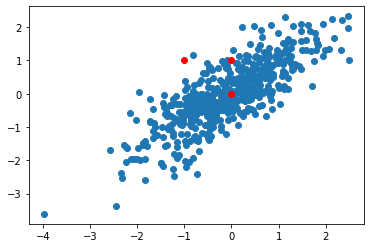

In [20]:
# plot x_eval 
x_train_PIT, _ = x_samples_train
plt.scatter(x_train_PIT[:,0], x_train_PIT[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

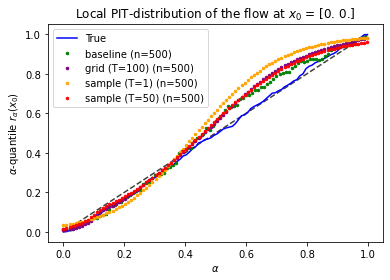

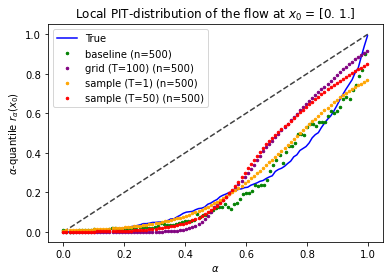

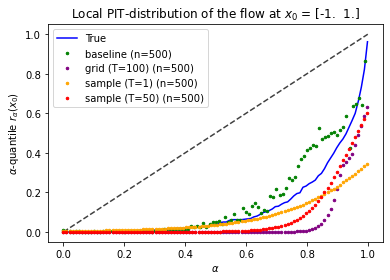

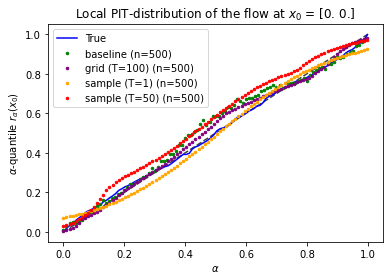

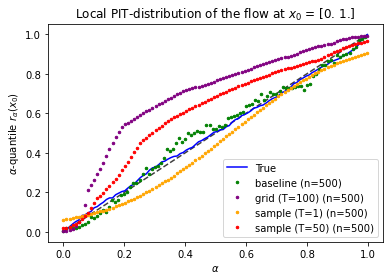

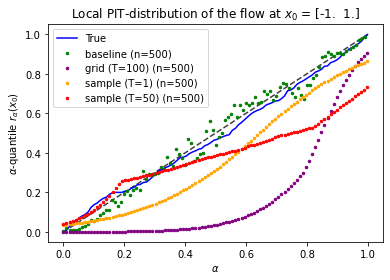

In [21]:
# show that for grid and sample methods 500 samples are not enough 

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=500,
    labels=labels,
)

#### Show that x_eval needs to be in training data distribution

In [22]:
# 5000 samples

methods = [
    localPIT_regression_baseline,
    localPIT_regression_grid,
    localPIT_regression_sample,
]
x_evals = [
    torch.FloatTensor([[0, 0]]),
    torch.FloatTensor([[0, 1]]),
    # torch.FloatTensor([[0, -1]]),
    # torch.FloatTensor([[1, 0]]),
    torch.FloatTensor([[-1, 1]]),
]

r_alpha_learned, labels, true_pit_values_bad, x_samples_train = run_localPIT_regression(
    methods,
    x_evals,
    nb_train_samples=5000,
    alpha_samples=[1, 50],
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_bad,
    feature_transform=first_dim_only,
)

r_alpha_learned_good, _, true_pit_values_good, _ = run_localPIT_regression(
    methods,
    x_evals,
    nb_train_samples=5000,
    alpha_samples=[1, 50],
    joint_data_generator=data_gen.get_joint_data,
    flow=maf_good,
    feature_transform=identity,
    samples_train=x_samples_train,
)

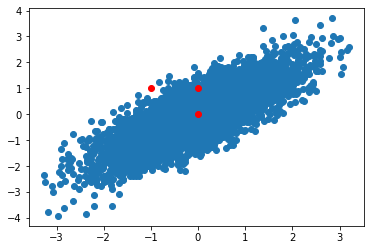

In [23]:
# plot x_eval 
x_train_PIT, _ = x_samples_train
plt.scatter(x_train_PIT[:,0], x_train_PIT[:,1])
x_evals = torch.stack(x_evals, axis=0)[:,0]
plt.scatter(x_evals[:,0], x_evals[:,1], color='red')

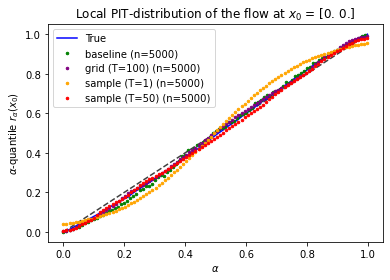

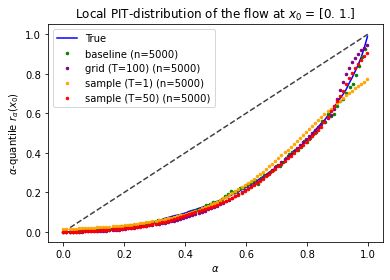

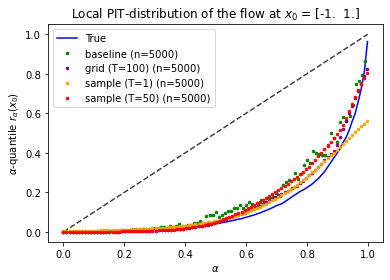

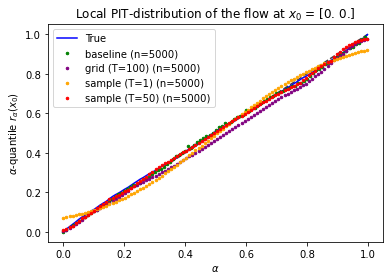

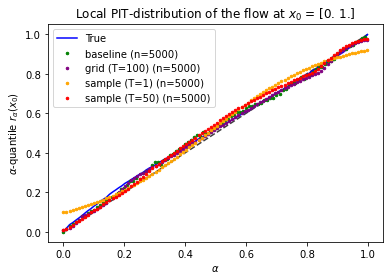

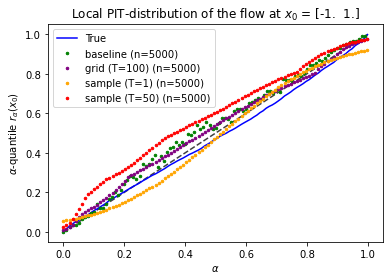

In [24]:
# show that x_eval needs to be in training data distribution

# bad maf
compare_pp_plots_regression(
    r_alpha_learned,
    true_pit_values_bad,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

# good maf
compare_pp_plots_regression(
    r_alpha_learned_good,
    true_pit_values_good,
    x_evals,
    nb_train_samples=5000,
    labels=labels,
)

500 samples were not enough for the 'amortized in alpha'-methods
- more to learn
- not enough x samples for the amount of alphas used
- x_eval has to be in the distribution of the train set, no generalisation outside of this range.
- the baseline can concentrate on learning point-estimates for a given alpha and lots of x samples --> better generalization w.r.t. x 

I tried for 5000 samples to train the classifiers.
- all methods work 
- grid-method does not work if x_eval is not in the distribution of the train set. 
- Overfit of grid-method, no generalisation outside of this range.

**PROBLEM:** to estimate the local PIT-distribution we need a ML algorithm that also requires summry statistics on X.